<a href="https://colab.research.google.com/github/b62mp1/ExistingResults/blob/main/Copy_of_Copy_of_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 7.8 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader
from pandas_datareader import data as pdr
yf.pdr_override()
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import *
from keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import datetime as dt
today=dt.date.today()
startDate=today-dt.timedelta(days=5*365)

In [4]:
stock_name = "AAPL"
#df=pdr.get_data_yahoo(stock_name, start=(startDate), end=today).reset_index()
df=pdr.get_data_yahoo(stock_name, start=('2014-07-10'), end='2019-07-10').reset_index()

print("Number of rows and columns:", df.shape)
df.head(5)

[*********************100%***********************]  1 of 1 completed
Number of rows and columns: (1258, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-07-10,23.440001,23.887501,23.379999,23.760000,21.312679,158744000
1,2014-07-11,23.840000,23.972500,23.715000,23.805000,21.353045,136072000
2,2014-07-14,23.965000,24.222500,23.912500,24.112499,21.628878,171240000
3,2014-07-15,24.200001,24.212500,23.757500,23.830000,21.375469,181911600
4,2014-07-16,24.242500,24.275000,23.684999,23.695000,21.254372,213585200


In [5]:
# Check for missing values
def num_missing(x):
    return sum(x.isnull())

print("Missing values per column:")
print(df.apply(num_missing, axis=0))

print("\nMissing values per row:")
print(df.apply(num_missing, axis=1).head())

Missing values per column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values per row:
0    0
1    0
2    0
3    0
4    0
dtype: int64


In [6]:

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [7]:
# Split the data into training and test datasets
split_index = 800
training_set = df.iloc[:split_index, 4:5].values
test_set = df.iloc[split_index:, 4:5].values

In [8]:
# Normalizing and reshaping the training data

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, split_index):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(740, 60, 1)

In [9]:
# Normalizing and reshaping the testing data
dataset_train = df.iloc[:split_index, 4:5]
dataset_test = df.iloc[split_index:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
Y_test = []
for i in range(60, len(dataset_total) - split_index + 60):
    X_test.append(inputs[i-60:i, 0])
    Y_test.append(inputs[i])
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(458, 60, 1)


In [10]:
# Building a moving average model
window = 20

# Create a moving average over the entire dataset
moving_avg = dataset_total.rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[split_index - window : dataset_total.index.max() - window + 1]

MAmse = mean_squared_error(dataset_test,moving_avg_forecast)
from math import sqrt
MArmse = sqrt(MAmse)
MAr2Score = r2_score(dataset_test,moving_avg_forecast)
MAmse,MArmse,MAr2Score

(20.93623423326508, 4.575612989891637, 0.16192009898658544)

In [11]:
# Building RNN model

# Clear any back end stored data due to multiple iterations
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size
window_size = 30

# Create 2D batches of batch size and features (1 feature = 1 time step in window)
train_set = window_dataset(training_set_scaled, window_size, batch_size=128)

# Establish Model
model_rnn = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Add a 3rd dimension (feature dimensionality which in this case in univariate)
                      input_shape=[None]), # 1st dimension is batch size, input shape = None allows windows of any size to be used
  keras.layers.SimpleRNN(100, return_sequences=True), # takes in sequence (batch size, time, dimensionality per time step (univariate))
  keras.layers.SimpleRNN(100), # produces a single vector
  keras.layers.Dense(1), # produces 1 output 
])

# Early stopping to prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=50, restore_best_weights=True)

# Put model all together
model_rnn.compile(loss='mean_squared_error',optimizer='adam')
model_rnn.fit(train_set, epochs=100, batch_size=32)

'''
Y_hat = model_rnn.predict(X_test)
RNNmse = mean_squared_error(Y_test,Y_hat)
from math import sqrt
RNNrmse = sqrt(RNNmse)
RNNr2Score = r2_score(Y_test,Y_hat)

RNNmse,RNNrmse,RNNr2Score
'''

Epoch 1/100
7/7 [==============================] - 3s 99ms/step - loss: 0.2712
Epoch 2/100
7/7 [==============================] - 0s 37ms/step - loss: 0.0733
Epoch 3/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0173
Epoch 4/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0085
Epoch 5/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0063
Epoch 6/100
7/7 [==============================] - 0s 33ms/step - loss: 0.0033
Epoch 7/100
7/7 [==============================] - 1s 55ms/step - loss: 0.0022
Epoch 8/100
7/7 [==============================] - 1s 62ms/step - loss: 0.0019
Epoch 9/100
7/7 [==============================] - 1s 72ms/step - loss: 0.0021
Epoch 10/100
7/7 [==============================] - 1s 67ms/step - loss: 0.0023
Epoch 11/100
7/7 [==============================] - 1s 88ms/step - loss: 0.0020
Epoch 12/100
7/7 [==============================] - 1s 59ms/step - loss: 0.0021
Epoch 13/100
7/7 [==============================]

'\nY_hat = model_rnn.predict(X_test)\nRNNmse = mean_squared_error(Y_test,Y_hat)\nfrom math import sqrt\nRNNrmse = sqrt(RNNmse)\nRNNr2Score = r2_score(Y_test,Y_hat)\n\nRNNmse,RNNrmse,RNNr2Score\n'

In [12]:
# Building ARIMA model

history = [x for x in dataset_train.values]
model_predictions = []
N_test_observations = len(dataset_test)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = dataset_test.values[time_point]
    history.append(true_test_value)

Amse = mean_squared_error(test_set,model_predictions)
from math import sqrt
Armse = sqrt(Amse)
Ar2Score = r2_score(test_set,model_predictions)
Amse,Armse,Ar2Score

(0.6166032558216868, 0.7852408903143588, 0.975317299670706)

In [13]:
# Predicting the values
# All values normalized to training data
spy_normalized_to_traindata = sc.transform(dataset_total.values.reshape(-1, 1))
rnn_forecast = model_forecast(
    model_rnn,
    spy_normalized_to_traindata[split_index - window_size:-1],
    window_size)[:, 0]
rnn_predicted_stock_price = sc.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
#rnn_predicted_stock_price.shape

RNNmse = mean_squared_error(dataset_test,rnn_predicted_stock_price)
from math import sqrt
RNNrmse = sqrt(RNNmse)
RNNr2Score = r2_score(dataset_test,rnn_predicted_stock_price)

RNNmse, RNNrmse, RNNr2Score

(19.128153904806823, 4.373574499743524, 0.23429776565841465)

In [14]:
# Method for plotting results
def plot_predictions(test, predicted_1, predicted_2, predicted_3, stock, total, index, dataframe):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(50,10))
    ax[0].plot(dataframe.loc[index:, 'Date'],test, color = 'red', label = 'Real ' + stock + ' Stock Price')
    ax[0].plot(dataframe.loc[index:, 'Date'],predicted_1, color = 'blue', label = 'Predicted ' + stock + ' Stock Price')
    ax[0].legend(loc="upper left")
    ax[1].plot(dataframe.loc[index:, 'Date'],test, color = 'red', label = 'Real ' + stock + ' Stock Price')
    ax[1].plot(dataframe.loc[index:, 'Date'],predicted_2, color = 'blue', label = 'Predicted ' + stock + ' Stock Price')
    ax[1].legend(loc="upper left")
    ax[2].plot(dataframe.loc[index:, 'Date'],test, color = 'red', label = 'Real ' + stock + ' Stock Price')
    ax[2].plot(dataframe.loc[index:, 'Date'],predicted_3, color = 'blue', label = 'Predicted ' + stock + ' Stock Price')
    ax[2].legend(loc="upper left")
    plt.title(stock + ' Stock Price Prediction using Moving Average, ARIMA, RNN respectively')
    plt.xlabel('Time')
    plt.ylabel(stock + 'Stock Price')
    plt.legend()
    plt.show()

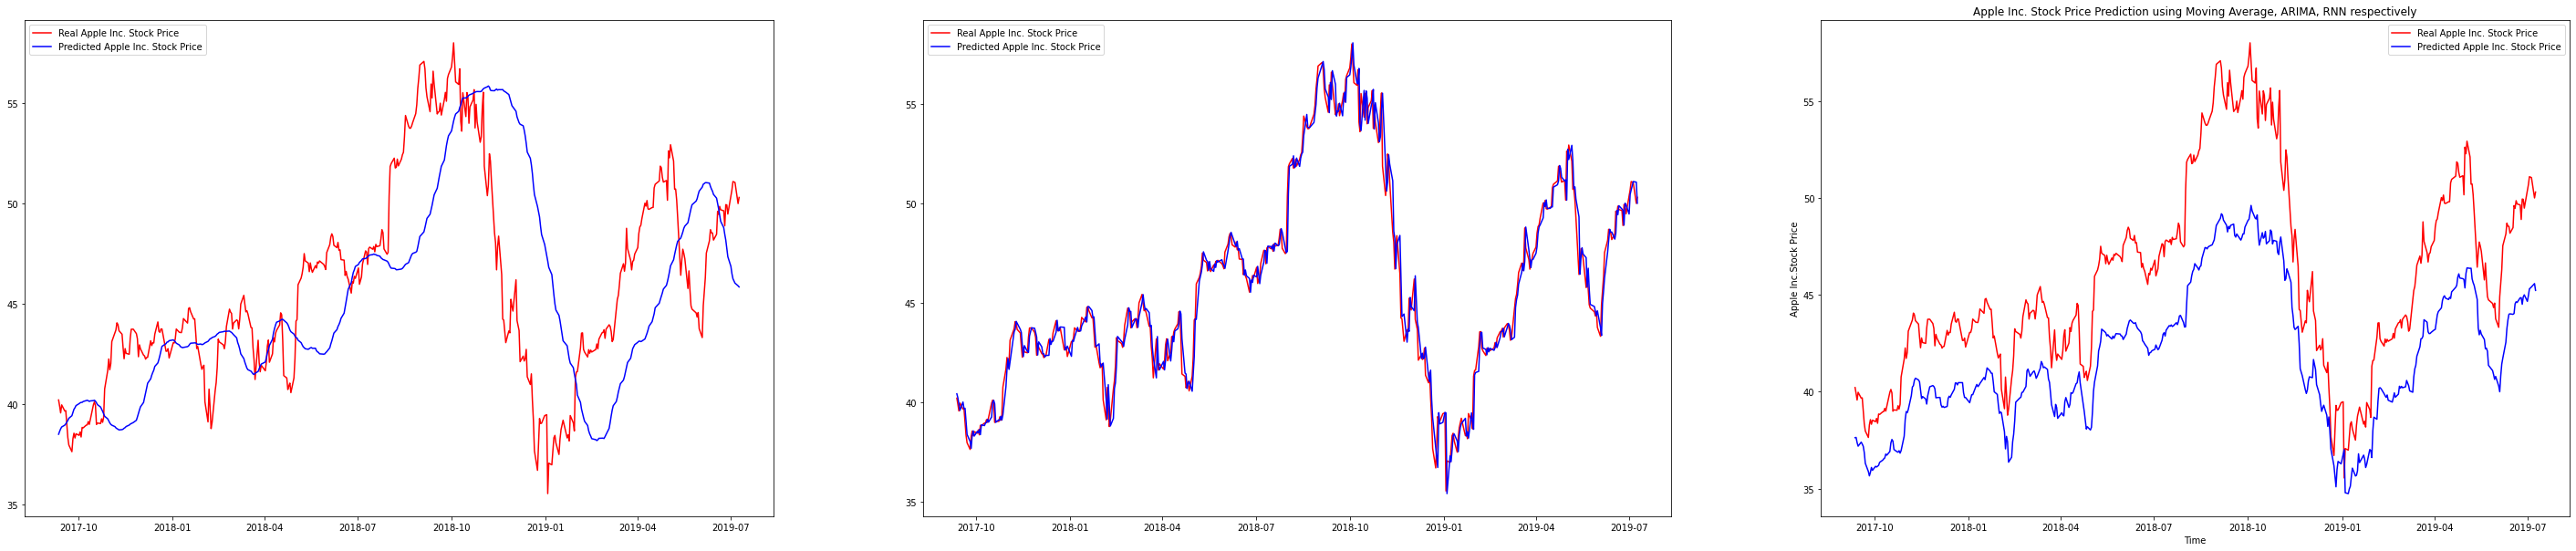

In [15]:
# Visualising the results
plot_predictions(dataset_test.values, moving_avg_forecast, model_predictions, rnn_predicted_stock_price, yf.Ticker(stock_name).info['longName'], len(dataset_total), split_index, df)

In [16]:
print("Moving Average ",MAmse,MArmse,MAr2Score)
print("Arima ",Amse,Armse,Ar2Score)
print("RNN ",RNNmse,RNNrmse,RNNr2Score)

Moving Average  20.93623423326508 4.575612989891637 0.16192009898658544
Arima  0.6166032558216868 0.7852408903143588 0.975317299670706
RNN  19.128153904806823 4.373574499743524 0.23429776565841465
